## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
sum((df.group == "treatment") & (df.landing_page != "new_page")) 

1965

In [7]:
df[(df.group == "treatment") & (df.landing_page == "old_page")].head(3)

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0


In [8]:
sum((df.group == "control") & (df.landing_page != "old_page"))

1928

In [9]:
df[(df.group == "control") & (df.landing_page != "old_page")].head(3)

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
490,808613,2017-01-10 21:44:01.292755,control,new_page,0


f. Do any of the rows have missing values?

In [10]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [11]:
df2 = df.drop(df.index[(df.group == "treatment") & (df.landing_page != "new_page")])
df2 = df2.drop(df.index[(df.group == "control") & (df.landing_page != "old_page")])

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
sum(df2.user_id.duplicated())

1

c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2 = df2.drop(2893)

In [17]:
sum(df2.user_id.duplicated())

0

In [18]:
df2.shape

(290584, 5)

In [19]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1




a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
df2[df2.group == "control" ].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
df2[df2.group == "treatment" ].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [23]:
df2.landing_page[df2.landing_page == "new_page"].count() / df2.landing_page.count()

0.50006194422266881

The probability of the controlled group to be converted is 12.03% and the probability of the treatment group is 11.88% which is think that the new page don't offer more conversion rate than the old page. Beside the probability of getting a new page to an indvidual is 50%. So until now there is no sufficient evidence to say that the new page leads to more conversions. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider I need to make the decision just based on all the data provided.  If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should my null and alternative hypotheses be?  

  **$H_{0}$**         :  **$p_{new}$** - **$p_{old}$**  ≤  0

   **$H_{1}$**        :  **$p_{new}$** - **$p_{old}$**  >  0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>



a. What is the **convert rate** for $p_{new}$ under the null? 

In [24]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [25]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [26]:
n_new = df2[df2.landing_page == "new_page"].shape[0]
n_new

145310

d. What is $n_{old}$?

In [27]:
n_old = df2[df2.landing_page == "old_page"].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted = np.random.choice([1,0], size = n_new , p = [p_new, (1 - p_new)]).mean()

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.choice([1,0], size = n_old , p = [p_old, (1 - p_old)]).mean()

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
new_page_converted - old_page_converted

8.0722452611065032e-05

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [31]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1,0], size = n_new , p = [p_new, (1 - p_new)]).mean()
    old_page_converted = np.random.choice([1,0], size = n_old , p = [p_old, (1 - p_old)]).mean()
    diffrance_n_o = new_page_converted - old_page_converted
    p_diffs.append(diffrance_n_o)

i. Plot a histogram of the **p_diffs**. 

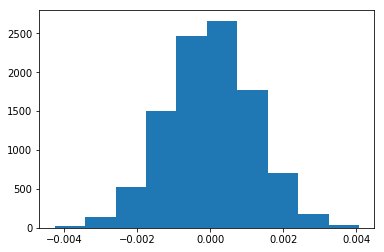

In [32]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [33]:
real_diff = df2[df2.landing_page == "new_page" ].converted.mean() - df2[df2.landing_page == "old_page" ].converted.mean()
p_diffs = np.array(p_diffs)
(p_diffs >  real_diff).mean()

0.90629999999999999

This is the p value which means that the probability of observing statistic or a more extreme value if the null is true.By comparing our p-value to our type I error threshold (α) which is 5%, we got a very large pval is greater than(α) which means that we fail to reject the null.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [34]:
import statsmodels.api as sm

convert_old = df2[(df2.landing_page == "old_page") & (df2.converted  == 1)].shape[0]
convert_new = df2[(df2.landing_page == "new_page") & (df2.converted  == 1)].shape[0]
n_old = df2[(df2.landing_page == "old_page")].shape[0]
n_new = df2[(df2.landing_page == "new_page")].shape[0]
convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute my test statistic and p-value.

In [35]:

stat, pval = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative="smaller")
stat, pval

(1.3109241984234394, 0.90505831275902449)

z-score means test statistic for the ztest pval it's our p value from the ztest. It agrees to our j and k results which mean that the pval is greater than the(α) which means fail to reject the null, we should keep the old page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, I will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should I be performing in this case?

Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model I specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, I first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2["intercept"] = 1
df2["ab_page"] = pd.get_dummies(df["landing_page"])["new_page"]

In [37]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [38]:
logit_model = sm.Logit(df2["converted"], df2[["intercept", "ab_page"]])
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 25 Oct 2020   Pseudo R-squ.:               8.077e-06
Time:                        07:50:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The pval here = 0.190 

In regression, pval is always giving for testing if the parameter for the slope is = 0 and the null hypothesis and the alternative using != 0, plus give us a hint about this variable is useful for predicting the response. In our case here pval =0.190 which is not significant for predicting the response, that means there is no significant difference in conversion based on if the individual receives the new page.

Adding more variables to our regression it could be helpful for our results to see each variable related to our response in our case individual convert, and how it could influence our response. but there are disadvantages when doing that like choosing variables that are not related to our response and related to one another and that will give us very misleading results. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. I will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  

Does it appear that country had an impact on conversion?

In [40]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [41]:
### Create the necessary dummy variables
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [42]:
df_new[["CA","UK","US"]]= pd.get_dummies(df_new["country"])
# Drop 1 column from the dummy varabile to make the matrices full rank.
df_new = df_new.drop(["CA"], axis=1)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [43]:
logit_model_country = sm.Logit(df_new["converted"], df_new[["intercept", "ab_page","UK","US"]])
result = logit_model_country.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 25 Oct 2020   Pseudo R-squ.:               2.323e-05
Time:                        07:54:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

All pval are bigger than our (α) .05% ,the variables here are not significant for predicting the response. which means there is no significant impact on conversion based on either the page or the country.

h. Though I have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  

In [44]:
### Fit Your Linear Model And Obtain the Results
df_new["US_page"] = df_new["ab_page"] * df_new["US"]
df_new["UK_page"] = df_new["ab_page"] * df_new["UK"]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,US_page,UK_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,0,1


In [45]:
logit_model_country_page = sm.Logit(df_new["converted"], df_new[["intercept", "US_page","UK_page"]])
result = logit_model_country_page.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 25 Oct 2020   Pseudo R-squ.:               1.082e-05
Time:                        07:57:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3164
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9926      0.008   -252.910      0.000      -2.008      -1.977
US_page       -0.0144      0.012     -1.155      0.248      -0.039       0.010
UK_page        0.0112      0.018      0.626      0.532      -0.024       0.046
==============================================================================
"""

The pvals here are more bigger than our (α) .05%, and this interacted variables are not significant for predicting the response. which means there is no significant impact on conversion based on the indvideuals that recieved the new page in these countrys.


The final result, there is no variable is statistically significant. and there is no impact on conversion based on either the country or the page that individuals received or both interacted.



<a id='conclusions'></a>
## Conclusions

There is no evidence that the new page is better than the old page for getting more conversions. In all methods above , as a result we should keep the old page. 

